In [72]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

cmap = sns.color_palette()

In [73]:
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1980')
asset = pdr.get_data_famafrench('17_Industry_Portfolios', start='1-1-1980')

In [74]:
df_FF = factor[0].loc['1980':'2021']
df_R = asset[0].loc['1980':'2021']
df_ER = df_R.subtract(df_FF.RF,axis=0).shift(1)

## Define variables and functions

In [75]:
S = df_R.cov()
R = df_R.mean(axis=0)
ER = df_ER.mean(axis=0)
N = len(ER)
ONE = np.ones(len(ER))

In [76]:
def pvar(w, S): 
    return (w.T @ S @ w)

def pret(w, ER): 
    return (w.T @ ER)

def sharpe(w, ER, S): 
    return -(w.T @ ER)/np.sqrt(w.T @ S @ w)

## Analytical solution (```GMVP``` and ```MSRP```)

In [77]:
GMVP = (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)
MSRP = (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)

In [78]:
MSRP.sum()

1.000000000000001

## Numerical solution (```NGMVP``` and ```NMSRP```)

In [79]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [80]:
# gmvp with no shortselling
from scipy.optimize import Bounds

bounds = Bounds(0, 1) # no margin trading and shortselling
x0 = GMVP
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})

NGMVPnoSS = minimize(pvar, x0, method='SLSQP', constraints=cons, args=S,
options={'disp': True, 'ftol': 1e-9}, 
bounds=bounds
)

NGMVPnoSS

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.854969582863784
            Iterations: 11
            Function evaluations: 204
            Gradient evaluations: 11


     fun: 11.854969582863784
     jac: array([23.70994103, 23.70991898, 23.80013967, 25.87363076, 25.18939853,
       26.76456118, 23.70994151, 27.70517874, 28.99906838, 24.97839618,
       24.2929498 , 26.4506129 , 25.5953269 , 23.70994163, 23.70992935,
       27.07527363, 23.70993149])
 message: 'Optimization terminated successfully'
    nfev: 204
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.65891358e-01, 1.78253723e-02, 0.00000000e+00, 2.22941486e-15,
       5.44454356e-16, 1.70453543e-15, 1.64582010e-01, 7.00082916e-15,
       6.49580970e-15, 0.00000000e+00, 4.23479416e-16, 5.24881605e-15,
       0.00000000e+00, 5.00381601e-01, 8.17961938e-02, 5.01930549e-15,
       6.95234642e-02])

In [81]:
# msrp with no shortselling
from scipy.optimize import Bounds

bounds = Bounds(0, 1)
x0 = MSRP

cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
NMSRPnoSS = minimize(sharpe, x0, method='SLSQP', constraints=cons, args=(ER, S),
options={'disp': True, 'ftol': 1e-9},
bounds=bounds)

NMSRPnoSS

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.22819911837659115
            Iterations: 15
            Function evaluations: 270
            Gradient evaluations: 15


     fun: -0.22819911837659115
     jac: array([-1.50874257e-07,  2.29488760e-02,  1.83588527e-02,  1.69858616e-02,
        7.69604668e-02,  5.41345757e-02,  6.15790486e-06,  2.72941124e-02,
        1.20903715e-01,  3.09783481e-02,  8.09325278e-03,  8.07456858e-03,
        3.30025144e-02, -6.94766641e-07, -6.73905015e-06,  4.14768849e-02,
        1.31459795e-02])
 message: 'Optimization terminated successfully'
    nfev: 270
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([2.52267115e-01, 7.64531938e-18, 1.71490291e-17, 2.65087431e-17,
       0.00000000e+00, 0.00000000e+00, 2.70913135e-01, 0.00000000e+00,
       0.00000000e+00, 1.48391702e-17, 1.25250762e-17, 1.01389844e-17,
       0.00000000e+00, 2.62122020e-01, 2.14697731e-01, 4.49096869e-18,
       1.48484876e-18])

## Backtesting 

### Define functions

In [82]:
S = df_R.cov()
R = df_R.mean(axis=0)
ER = df_ER.mean(axis=0)
N = len(ER)
ONE = np.ones(len(ER))

In [83]:
def GMVP(S): # for analytical GMVP
    ONE = np.ones(len(S))
    return (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)

def MSRP(ER, S): # for analytical MSRP
    ONE = np.ones(len(S))
    return (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)



def pvar(w, S): # for numerical GMVP
    return (w.T @ S @ w)

def sharpe(w, ER, S): # for numerical MSRP
    return -(w.T @ ER)/np.sqrt(w.T @ S @ w)


def NGMVPnoSS(S): # for numerical GMVP
    x0 = GMVP(S)
    cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
    bounds = Bounds(0, 1)

    return minimize(pvar, x0, method='SLSQP', constraints=cons, args=S, 
    options={'disp': True, 'ftol': 1e-9},
    bounds=bounds
    )

def NMSRPnoSS(ER, S): # for numerical MSRP
    x0 = MSRP(ER, S)
    cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
    bounds = Bounds(0, 1)

    return minimize(sharpe, x0, method='SLSQP', constraints=cons, args=(ER, S),
    options={'disp': True, 'ftol': 1e-9},
    bounds=bounds)

def pret(w, ER): 
    return (w.T @ ER)

In [84]:
egg = NMSRPnoSS(ER, S)
egg.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.22819911837659115
            Iterations: 15
            Function evaluations: 270
            Gradient evaluations: 15


array([2.52267115e-01, 7.64531938e-18, 1.71490291e-17, 2.65087431e-17,
       0.00000000e+00, 0.00000000e+00, 2.70913135e-01, 0.00000000e+00,
       0.00000000e+00, 1.48391702e-17, 1.25250762e-17, 1.01389844e-17,
       0.00000000e+00, 2.62122020e-01, 2.14697731e-01, 4.49096869e-18,
       1.48484876e-18])

In [85]:
import timeit
start = timeit.default_timer()

WSize = 60 # rolling period: 5 years
AvgER_rolling = df_ER.rolling(WSize).mean() 
CovER_rolling = df_ER.rolling(WSize).cov() 

Backtest_R = pd.DataFrame(index=df_R.index,columns=['GMVP','MSRP', 'NGMVPnoSS', 'NMSRPnoSS', 'EW'])

for d in df_ER.index:
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]

    Backtest_R.loc[d,'GMVP'] = pret(GMVP(S), R)
    Backtest_R.loc[d,'MSRP'] = pret(MSRP(ER, S), R) 
    Backtest_R.loc[d, 'NGMVPnoSS'] = pret(NGMVPnoSS(S).x, R) # x is the weight array we need 
    Backtest_R.loc[d, 'NMSRPnoSS'] = pret(NMSRPnoSS(ER, S).x, R)


# EW
Backtest_R.loc[:,'EW'] = df_R.mean(axis=1)

Backtest_R = Backtest_R.loc[(df_R.index[0] + WSize):]

stop = timeit.default_timer()
print('Time: ', stop - start)  

Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function 

## Backtest using parallel computing

In [89]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

In [92]:
type(R)

pandas.core.series.Series

In [96]:
a = pool.apply( NGMVPnoSS(S)) 

Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101


TypeError: 'OptimizeResult' object is not callable

In [87]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

import timeit
start = timeit.default_timer()

WSize = 60 # rolling period: 5 years
AvgER_rolling = df_ER.rolling(WSize).mean() 
CovER_rolling = df_ER.rolling(WSize).cov() 

Backtest_R = pd.DataFrame(index=df_R.index,columns=['GMVP','MSRP', 'NGMVPnoSS', 'NMSRPnoSS', 'EW'])

for d in df_ER.index:
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]

    Backtest_R.loc[d,'GMVP'] = pret(GMVP(S), R)
    Backtest_R.loc[d,'MSRP'] = pret(MSRP(ER, S), R) 
    Backtest_R.loc[d, 'NGMVPnoSS'] = [pool.apply( pret(NGMVPnoSS(S).x, R) )] 
    Backtest_R.loc[d, 'NMSRPnoSS'] = [pool.apply( pret(NMSRPnoSS(ER, S).x, R) ) ]


# EW
Backtest_R.loc[:,'EW'] = df_R.mean(axis=1)

Backtest_R = Backtest_R.loc[(df_R.index[0] + WSize):]

stop = timeit.default_timer()
print('Time: ', stop - start) 


Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101


TypeError: 'numpy.float64' object is not callable

--- 

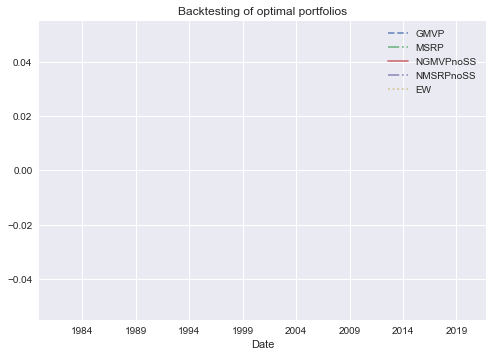

In [97]:
plt.style.use('seaborn')

CumRet = (1 + Backtest_R.divide(100)).cumprod() 
CumRet['GMVP'].plot(alpha=0.75, linestyle="--")
CumRet['MSRP'].plot(alpha=0.75, linestyle="-.")
CumRet['NGMVPnoSS'].plot(alpha=0.75, linestyle="solid")
CumRet['NMSRPnoSS'].plot(alpha=0.75, linestyle="dashdot")
CumRet['EW'].plot(alpha=0.75, linestyle=":")

plt.legend()
plt.title('Backtesting of optimal portfolios')
plt.show()